In [1]:
# === Imports ===
import pandas as pd
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.stats as stats



In [2]:


# Load the saved processed data
load_path = r"C:\Users\User\OneDrive\Projects\TradingSystem\TWSAPI\Data\TSLA_kalman_processed.csv"
df = pd.read_csv(load_path, parse_dates=['Datetime'])
df = df.set_index('Datetime')

print("Loaded DataFrame shape:", df.shape)
# print(df.head())


Loaded DataFrame shape: (9360, 22)


In [3]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Mid', 'Spread',
       'Spread_smooth', 'var_dMid', 'var_acc', 'KF_level_fixed',
       'KF_slope_fixed', 'KF_curv_fixed', 'KF_level_var_fixed',
       'KF_slope_var_fixed', 'KF_curv_var_fixed', 'KF_level_adapt',
       'KF_slope_adapt', 'KF_curv_adapt', 'KF_level_var_adapt',
       'KF_slope_var_adapt', 'KF_curv_var_adapt'],
      dtype='object')

**Plot price and filtered price to compare**

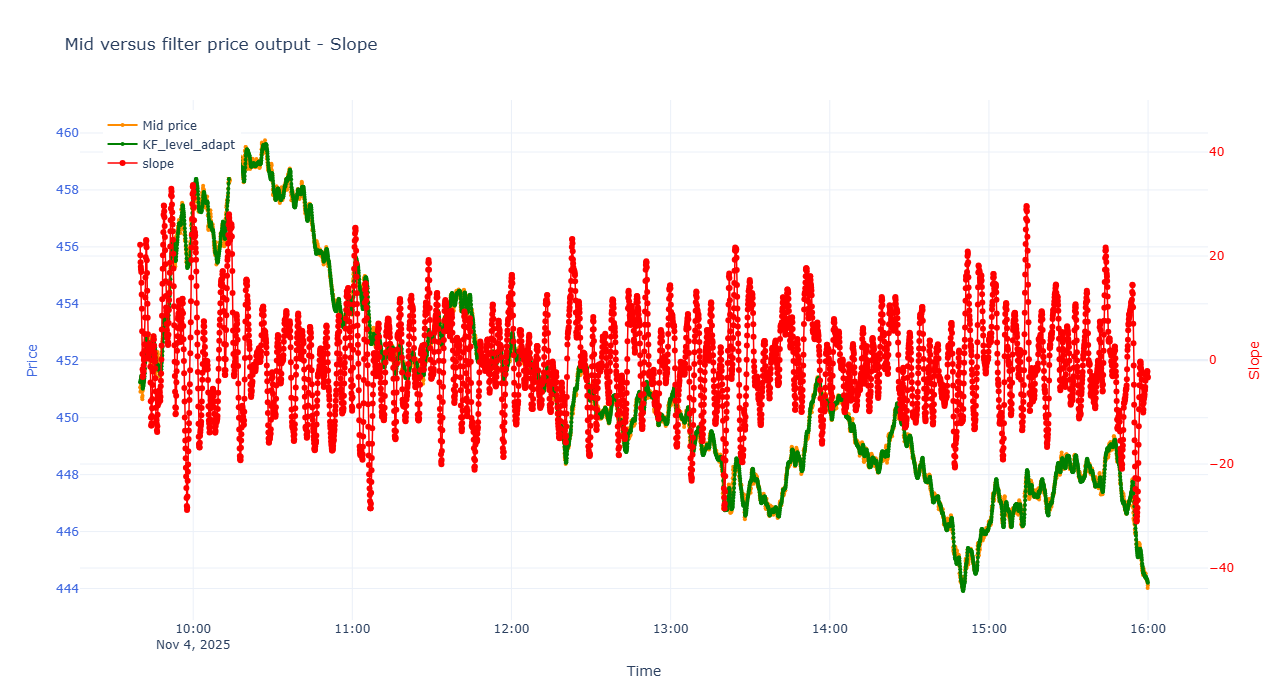

In [8]:
start = '2025-11-04 09:40:00-05:00'
# end   = '2025-11-03 12:00:55-05:00'
end   = '2025-11-04 15:59:55-05:00'
df_range = df[(df.index >= start) & (df.index <= end)]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_range.index,
    y=df_range['Mid'],
    mode='lines+markers',  # show both lines and dots
    name='Mid price',
    line=dict(color='darkorange', width=2),
    marker=dict(size=4, color='darkorange'),  # small dots
    yaxis='y1'
))
fig.add_trace(go.Scatter(
    x=df_range.index,
    y=df_range['KF_level_adapt'],
    mode='lines+markers',  # show both lines and dots
    name='KF_level_adapt',
    line=dict(color='green', width=2),
    marker=dict(size=4, color='green'),  # small dots
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=df_range.index, y=1000*df_range['KF_slope_adapt'],
    mode='lines+markers', name='slope',
    line=dict(color='red', width=1.5),
    yaxis='y2'
))


fig.update_layout(
    title='Mid versus filter price output - Slope',
    xaxis=dict(title='Time'),
    # xaxis=dict(title='Time', automargin=True, rangeslider=dict(visible=False), constrain='domain'),
    yaxis=dict(title='Price', color='royalblue'),
    yaxis2=dict(
        title='Slope',
        color='red',
        overlaying='y',  # share the same x-axis
        side='right',
        range=[-50,50]
    ),
    legend=dict(x=0.02, y=0.98),
    height=700,
    width=1000,
    template='plotly_white',
    hovermode='x unified'
    
)



fig.show()

**calculation of probability of extremum in derivative**


In [35]:
data = df_range['KF_level_adapt'].dropna().values
data_sorted = np.sort(data)
n = len(data_sorted)

# right-side ECDF: P(X ≤ x)
def ecdf_right(x):
    return np.searchsorted(data_sorted, x, side='right') / n

# left-side ECDF: P(X < x)
def ecdf_left(x):
    return np.searchsorted(data_sorted, x, side='left') / n


pos_mask = data > 0
neg_mask = data < 0

prob_percent = np.zeros_like(data, dtype=float)

# For positive x → right tail probability
prob_percent[pos_mask] = (1 - ecdf_right(data[pos_mask])) * 100

# For negative x → left tail probability
prob_percent[neg_mask] = (ecdf_left(data[neg_mask])) * 100



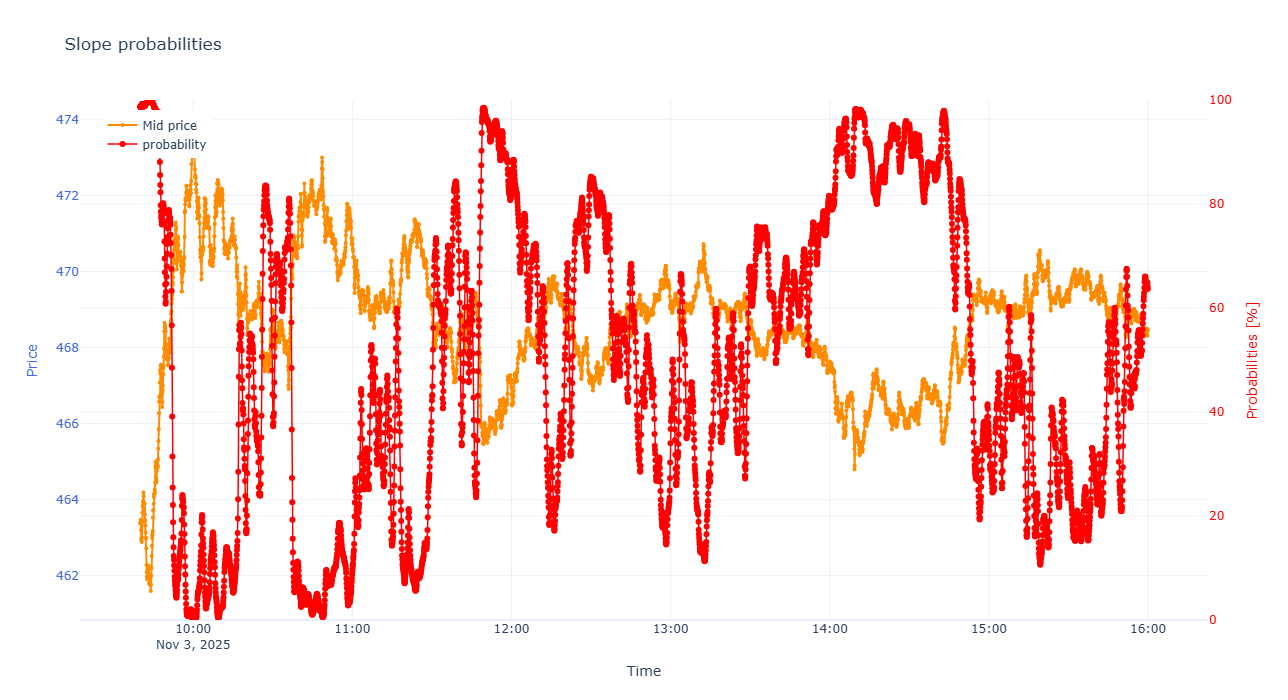

In [36]:
thr_up=90
thr_down=10

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_range.index,
    y=df_range['Mid'],
    mode='lines+markers',  # show both lines and dots
    name='Mid price',
    line=dict(color='darkorange', width=2),
    marker=dict(size=4, color='darkorange'),  # small dots
    yaxis='y1'
))

# fig.add_trace(go.Scatter(
#     x=df_range.index,
#     y=1000*df_range['KF_slope_adapt'],
#     mode='lines+markers',  # show both lines and dots
#     name='KF_slope_adapt',
#     line=dict(color='green', width=2),
#     marker=dict(size=4, color='green'),  # small dots
#     yaxis='y1'
# ))

# markers where P0 exceeds threshold
# mask = prob_percent > thr_up
# fig.add_trace(go.Scatter(
#     x=df_range.index[mask],
#     y=df_range['Mid'][mask],
#     mode='markers',
#     marker=dict(color='black', size=6, symbol='circle'),
#     name='High up probability',
#     yaxis='y2'
# ))

fig.add_trace(go.Scatter(
    x=df_range.index, y=prob_percent,
    mode='lines+markers', name='probability',
    line=dict(color='red', width=1.5),
    yaxis='y2'
))


fig.update_layout(
    title='Slope probabilities',
    xaxis=dict(title='Time'),
    # xaxis=dict(title='Time', automargin=True, rangeslider=dict(visible=False), constrain='domain'),
    # yaxis=dict(title='Slope', color='royalblue'),
    yaxis=dict(title='Price', color='royalblue'),
    yaxis2=dict(
        title='Probabilities [%]',
        color='red',
        overlaying='y',  # share the same x-axis
        side='right',
        range=[-0,100]
    ),
    legend=dict(x=0.02, y=0.98),
    height=700,
    width=1000,
    template='plotly_white',
    hovermode='x unified'
    
)



fig.show()

**Plot points with high probability on price graph**

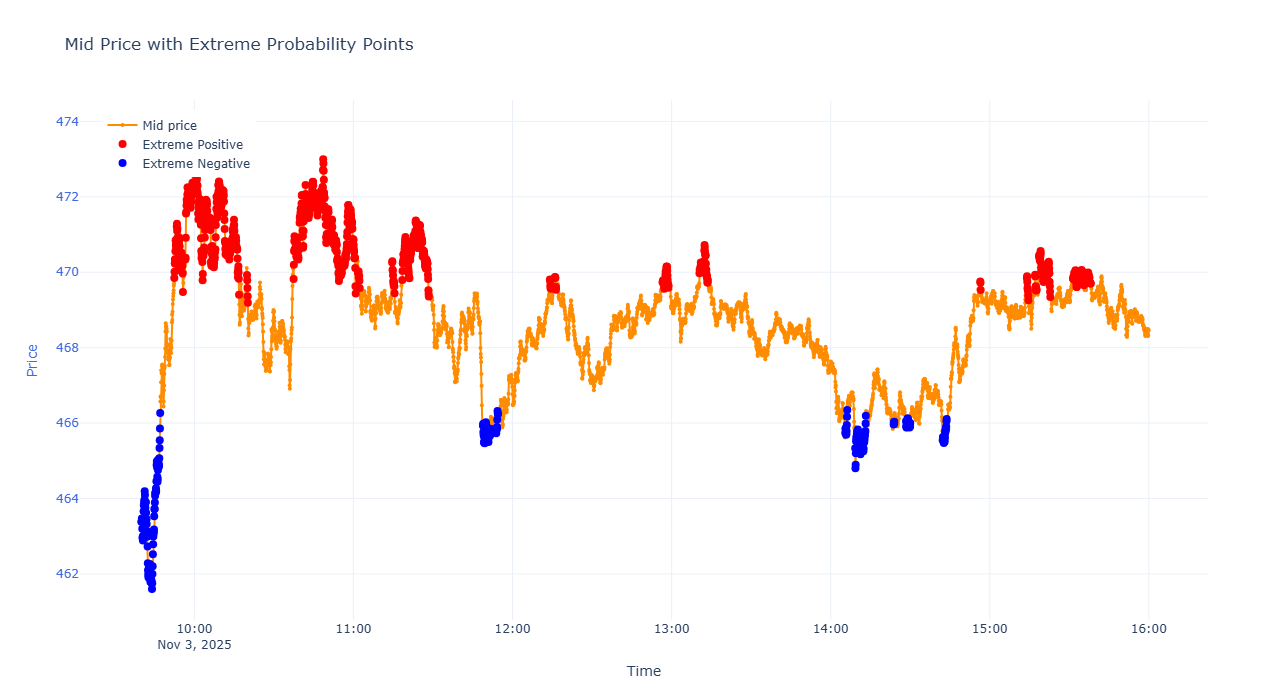

In [46]:
# Add the probabilities to the data frame.
# Create a mask to see on prices graph

prob_series = pd.Series(prob_percent, index=df_range['KF_level_adapt'].dropna().index)

df_range.loc[prob_series.index, 'prob_extreme'] = prob_series

mask_low  = df_range['prob_extreme'] < 20      # extreme positive
mask_high = df_range['prob_extreme'] > 95    # extreme negative


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_range.index,
    y=df_range['Mid'],
    mode='lines+markers',  # show both lines and dots
    name='Mid price',
    line=dict(color='darkorange', width=2),
    marker=dict(size=4, color='darkorange'),  # small dots
    yaxis='y1'
))

# --- Mark EXTREME POSITIVE points (<5%) ---
fig.add_trace(go.Scatter(
    x=df_range.index[mask_low],
    y=df_range['Mid'][mask_low],
    mode='markers',
    name='Extreme Positive',
    marker=dict(color='red', size=8, symbol='circle'),
))

# --- Mark EXTREME NEGATIVE points (>90%) ---
fig.add_trace(go.Scatter(
    x=df_range.index[mask_high],
    y=df_range['Mid'][mask_high],
    mode='markers',
    name='Extreme Negative',
    marker=dict(color='blue', size=8, symbol='circle'),
))

fig.update_layout(
    
    
)

fig.update_layout(
    title='Mid Price with Extreme Probability Points',
    xaxis=dict(title='Time'),
    # xaxis=dict(title='Time', automargin=True, rangeslider=dict(visible=False), constrain='domain'),
    # yaxis=dict(title='Slope', color='royalblue'),
    yaxis=dict(title='Price', color='royalblue'),
    # yaxis2=dict(
    #     title='Probabilities [%]',
    #     color='red',
    #     overlaying='y',  # share the same x-axis
    #     side='right',
    #     range=[-0,100]
    # ),
    legend=dict(x=0.02, y=0.98),
    height=700,
    width=1000,
    template='plotly_white',
    hovermode='x unified',
    # hovermode='x'
    showlegend=True
    
)

fig.show()







**AI Suggestions to inspect**

✔ Make it rolling (sliding window ECDF)
✔ Combine this with density estimation (KDE)
✔ Detect anomalies based on tail probability thresholds
✔ Rolling ECDF (probability over a sliding window)
✔ Conditional probabilities
✔ Smoothed PDF + CDF using KDE
✔ ECDF-based anomaly detection
✔ A rolling version: “How extreme is this value compared to last N samples?”
✔ A conditional version: P(X > x | X > 0)
✔ A smoothed empirical PDF+CDF using KDE
✔ A 2D ECDF (joint probability of two variables)
✔ Computing rolling ECDF

(“probability of x compared to last N samples”)

✔ Conditional probabilities

(e.g., P(X > x | X > 0))

✔ Probability heatmaps

(two-dimensional ECDF)

✔ Using ECDF to detect regime changes

(change-point detection)

OK. Let's start with implementation of your suggestions and see where this leads. I have the following: A numpy array: ```prob_percent```, and a pandas series: ```prob_series = pd.Series(prob_percent, index=df_range['KF_level_adapt'].dropna().index)```


**Cleaning probability and entrance signal generation**

In [76]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. Directional ECDF probabilities
# -----------------------------
df = df_range.copy()

data = df['KF_slope_adapt'].dropna().values
data_sorted = np.sort(data)
n = len(data_sorted)

def ecdf(x):
    return np.searchsorted(data_sorted, x, side='right') / n

# compute F for KF_level_adapt (vectorized)
F = ecdf(data)

# directional tail probabilities
prob_low  = (1-F) * 100           # P(X is extremely LOW)
prob_high = F * 100     # P(X is extremely HIGH)

# assign to dataframe (aligned index)
idx = df['KF_slope_adapt'].dropna().index
df.loc[idx, 'prob_low']  = prob_low
df.loc[idx, 'prob_high'] = prob_high

# -----------------------------
# 2. Add signal columns
# -----------------------------
df['signal_short'] = 0
df['signal_long']  = 0

price = df['Mid']

# -----------------------------
# 3. PARAMETERS
# -----------------------------
# Short: high tail (top)
P_enter_short = 98.0
P_exit_short  = 96.0

# Long: low tail (bottom)
P_enter_long = 98.0
P_exit_long  = 97.0

RETRACE_PCT = 0.00003     # 0.003%
COOLDOWN_BARS = 2       # 2 bars

# -----------------------------
# 4. STATE MACHINE
# -----------------------------
state = "FLAT"  # FLAT, SHORT_ZONE, LONG_ZONE, COOLDOWN
cooldown_until = -1

short_extreme_price = None
long_extreme_price  = None

for t in range(len(df)):

    p_low  = df['prob_low'].iloc[t]
    p_high = df['prob_high'].iloc[t]
    mid = price.iloc[t]

    # ---- COOLDOWN ----
    if state == "COOLDOWN":
        if t >= cooldown_until:
            state = "FLAT"
        else:
            continue

    # ==============================
    # ENTER ZONES FROM FLAT STATE
    # ==============================
    if state == "FLAT":

        # Enter SHORT zone (price top) → extreme HIGH tail prob
        if p_high >= P_enter_short:
            state = "SHORT_ZONE"
            short_extreme_price = mid
            continue

        # Enter LONG zone (price bottom) → extreme LOW tail prob
        if p_low >= P_enter_long:
            state = "LONG_ZONE"
            long_extreme_price = mid
            continue

    # ==============================
    # SHORT ZONE (look for top and retrace DOWN)
    # ==============================
    if state == "SHORT_ZONE":

        # Update swing HIGH while probability is still extreme enough
        if p_high >= P_exit_short:
            if mid > short_extreme_price:
                short_extreme_price = mid

        # Conditions for exit + retrace confirmation
        prob_exit = (p_high < P_exit_short)
        retrace = (short_extreme_price - mid) / short_extreme_price >= RETRACE_PCT

        if prob_exit and retrace:
            # SHORT ENTRY
            df.at[df.index[t], 'signal_short'] = 1

            # Cooldown
            state = "COOLDOWN"
            cooldown_until = t + COOLDOWN_BARS
            short_extreme_price = None
            continue

        # If probability leaves zone but retrace not reached → abandon
        if prob_exit and not retrace:
            state = "FLAT"
            short_extreme_price = None
            continue

    # ==============================
    # LONG ZONE (look for bottom and retrace UP)
    # ==============================
    if state == "LONG_ZONE":

        # Update swing LOW while probability is still extreme
        if p_low >= P_exit_long:
            if mid < long_extreme_price:
                long_extreme_price = mid

        # Exit conditions
        prob_exit = (p_low < P_exit_long)
        retrace = (mid - long_extreme_price) / long_extreme_price >= RETRACE_PCT

        if prob_exit and retrace:
            # LONG ENTRY
            df.at[df.index[t], 'signal_long'] = 1

            # Cooldown
            state = "COOLDOWN"
            cooldown_until = t + COOLDOWN_BARS
            long_extreme_price = None
            continue

        # If exit zone but no retrace → abandon
        if prob_exit and not retrace:
            state = "FLAT"
            long_extreme_price = None
            continue


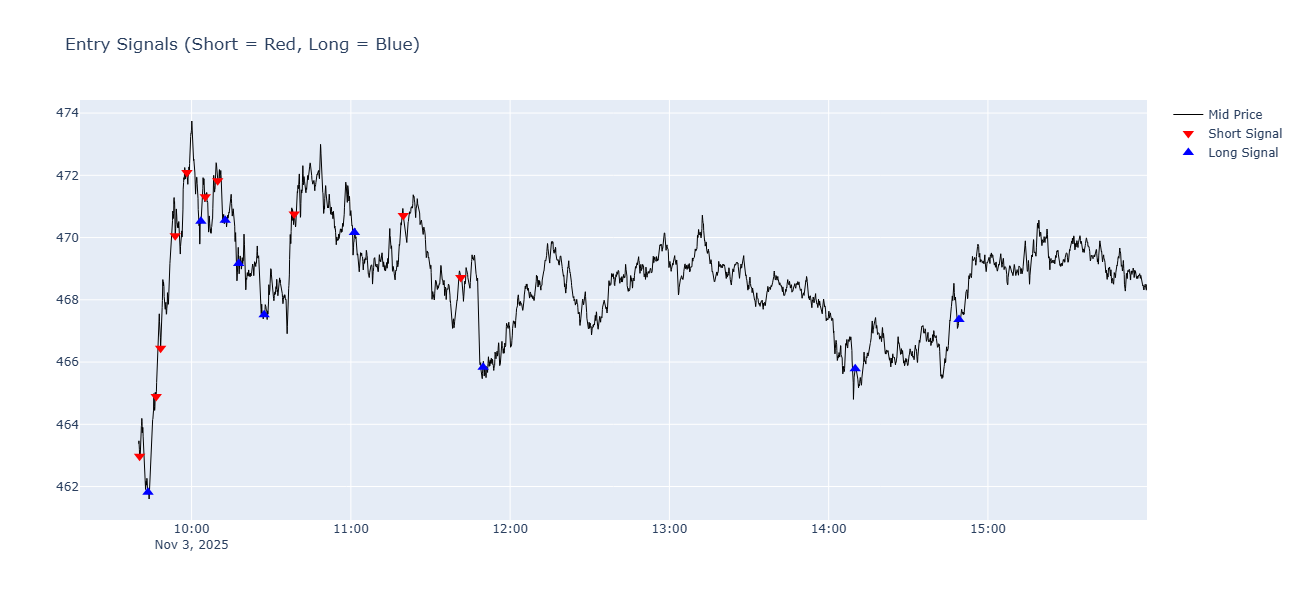

In [77]:


fig = go.Figure()

# --- Mid Price ---
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Mid'],
    mode='lines',
    name='Mid Price',
    line=dict(color='black', width=1)
))

# --- SHORT Signals (red) ---
short_idx = df.index[df['signal_short'] == 1]
fig.add_trace(go.Scatter(
    x=short_idx,
    y=df.loc[short_idx, 'Mid'],
    mode='markers',
    name='Short Signal',
    marker=dict(color='red', size=10, symbol='triangle-down')
))

# --- LONG Signals (blue) ---
long_idx = df.index[df['signal_long'] == 1]
fig.add_trace(go.Scatter(
    x=long_idx,
    y=df.loc[long_idx, 'Mid'],
    mode='markers',
    name='Long Signal',
    marker=dict(color='blue', size=10, symbol='triangle-up')
))

fig.update_layout(
    title="Entry Signals (Short = Red, Long = Blue)",
    hovermode="x unified",
    showlegend=True,
    height=600
)

fig.show()


In [54]:
df[['signal_short', 'signal_long']].sum()


signal_short    0
signal_long     0
dtype: int64

In [55]:
print("max prob =", df['prob_extreme'].max())
print("min prob =", df['prob_extreme'].min())


max prob = 99.97807017543859
min prob = 0.0


In [56]:
max_short_retrace = 0
max_long_retrace = 0

for t in range(len(df)):
    # For short retrace
    if not np.isnan(df['Mid'].iloc[t]):
        # This is an approximation to see the scale of swings:
        max_short_retrace = max(max_short_retrace, df['Mid'].pct_change().abs().max())

print("Max price pct move:", df['Mid'].pct_change().abs().max())


Max price pct move: 0.0014970695659560773


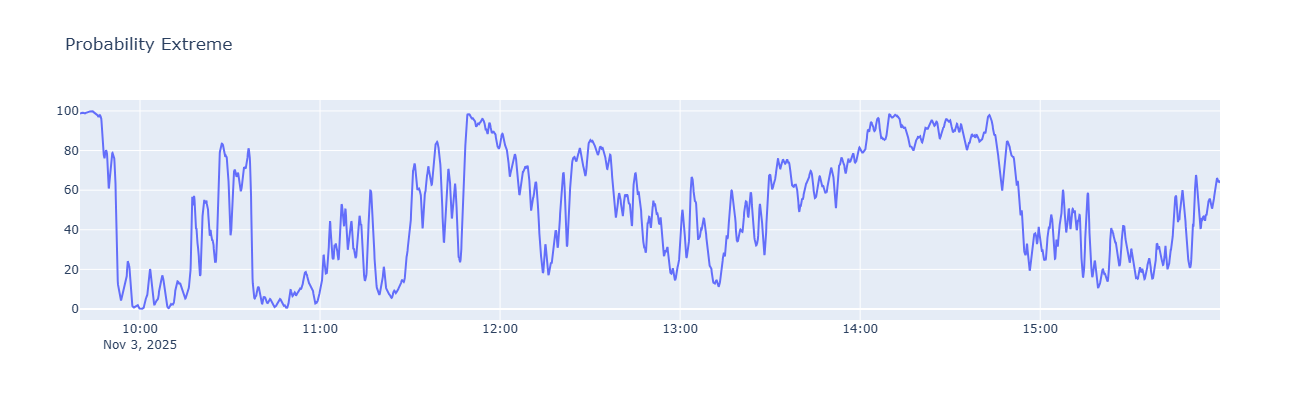

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['prob_extreme'], mode='lines'))
fig.update_layout(height=400, title='Probability Extreme')
fig.show()
